# Prediction on Test Set

In [ ]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

In [ ]:
!pip install -q catboost
!pip install category_encoders


## Load Test Data

In [ ]:

# Environment Setup - Import Libraries
import os
import gc
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

In [ ]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")
test  = pd.read_parquet(DATA_DIR / "test_features.parquet")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Sort for time-series
train = train.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)
test  = test.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)

gc.collect()

In [ ]:
# Load All Saved Models and Artifacts

# Random Forest
rf_model = joblib.load("models/random_forest/random_forest.pkl")

# Target Encoder
target_encoder = joblib.load("models/random_forest/target_encoder.pkl")

# CatBoost
cat_model = CatBoostRegressor()
cat_model.load_model("models/catboost/catboost.cbm")

# LightGBM
lgb_model = lgb.Booster(model_file="models/lightgbm/baseline_lightgbm.txt")

# XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgboost/xgboost.json")

In [ ]:
# Load Final Ensemble Bundle
bundle = joblib.load("models/ensemble-stacking/final_ensemble_model.pkl")

print("Loaded Ensemble Bundle Keys: ")
for key in bundle.keys():
  print( " -", key)

In [ ]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()


In [59]:
# Build the Unified History Store
MAX_LAG = max(LAGS)
history_df = train[train['date'] >= (train['date'].max() - pd.Timedelta(days=MAX_LAG + 30))][
    ["store_nbr", "family", "date", "sales", "onpromotion", "dcoilwtico"]
].copy()

history_df = history_df.sort_values(
    ["store_nbr", "family", "date"]
).reset_index(drop=True)

In [ ]:
# Sales Lag / Roll Features
def generate_sales_features(history, current_rows, lags, rolls):
    for lag in lags:
        current_rows[f"sales_lag_{lag}"] = (
            history.groupby(["store_nbr", "family"])["sales"]
            .shift(lag)
            .reindex(current_rows.index)
        )

    for r in rolls:
        roll = (
            history.groupby(["store_nbr", "family"])["sales"]
            .rolling(r)
            .agg(["mean", "std"])
            .reset_index(level=[0,1], drop=True)
        )
        current_rows[f"sales_roll_mean_{r}"] = roll["mean"].reindex(current_rows.index)
        current_rows[f"sales_roll_std_{r}"]  = roll["std"].reindex(current_rows.index)

    return current_rows


In [ ]:
# Promo Features
def generate_promo_features(history, current_rows, lags, rolls):
    for lag in lags:
        current_rows[f"promo_lag_{lag}"] = (
            history.groupby(["store_nbr", "family"])["onpromotion"]
            .shift(lag)
            .reindex(current_rows.index)
        )

    for r in rolls:
        rolling = (
            history.groupby(["store_nbr", "family"])["onpromotion"]
            .rolling(r)
        )
        current_rows[f"promo_roll_sum_{r}"] = rolling.sum().reset_index(level=[0,1], drop=True)
        current_rows[f"promo_freq_{r}"] = (
            rolling.mean().reset_index(level=[0,1], drop=True)
        )

    current_rows["promo_flag"] = (current_rows["onpromotion"] > 0).astype(int)

    return current_rows


In [ ]:
# Oil Lag Features
def generate_oil_features(history, current_rows, lags):
    for lag in lags:
        current_rows[f"oil_lag_{lag}"] = (
            history.groupby("store_nbr")["dcoilwtico"]
            .shift(lag)
            .reindex(current_rows.index)
        )
    return current_rows


In [61]:
# Recursive Test Feature Generation Loop
LAGS  = [1, 7, 14, 28]
ROLLS = [7, 14, 28]

test_preds_list = []
test_dates = sorted(test["date"].unique())

for current_date in test_dates:

    test_day = test[test["date"] == current_date].copy()

    temp_history = pd.concat([history_df, test_day], ignore_index=True)

    test_day = generate_sales_features(temp_history, test_day, LAGS, ROLLS)
    test_day = generate_promo_features(temp_history, test_day, [1,7], ROLLS)
    test_day = generate_oil_features(temp_history, test_day, [7,14,28])

    # BACKFILL INSTEAD OF DROP
    test_day = test_day.bfill().ffill()

    test_preds.append(test_day)



In [62]:
# Final Test Features
test_feature_full = pd.concat(test_preds).reset_index(drop=True)
test_feature_full = reduce_mem_usage(test_feature_full)

print("Test Feature Shape: ", test_feature_full.shape)

Test Feature Shape:  (28512, 60)


In [63]:
# Drop Unneceaary Columns in Test Set
DROP_COLS = ["id", "date", "sales", "sales_log"]

TRAIN_FEATURES = [
    col for col in train.columns
    if col not in DROP_COLS
]

# Drop Forbidden Columns
test_feature_full = test_feature_full.drop(
    columns=[c for c in ["sales", "sales_log"] if c in test_feature_full],
    errors="ignore"
)

test_features_full = test_feature_full[TRAIN_FEATURES]


print(f"Total train features: {len(TRAIN_FEATURES)}")


Total train features: 58


In [64]:
assert test_features_full.shape[1] == len(TRAIN_FEATURES)
assert test_features_full.isnull().sum().sum() == 0

print("Feature validation PASSED")
print("Test shape:", test_features_full.shape)


Feature validation PASSED
Test shape: (28512, 58)


In [65]:
# Prepare Inputs
X_test_te = bundle["target_encoder"].transform(test_features_full)
X_test_raw = test_features_full.copy()

In [66]:
# Final Prediction Function

def predict_from_bundle(X_raw, bundle):
    """
    X_raw : DataFrame with EXACT training features
    returns : sales predictions (original scale)
    """

    # Target encoding (RF + XGB)
    X_te = bundle["target_encoder"].transform(X_raw)

    # Base model predictions (LOG scale)
    preds = np.column_stack([
        bundle["rf_model"].predict(X_te),
        bundle["xgb_model"].predict(xgb.DMatrix(X_te)),
        bundle["lgb_model"].predict(
            X_raw,
            num_iteration=bundle["lgb_model"].best_iteration
        ),
        bundle["cat_model"].predict(X_raw),
    ])

    # Meta-model (stacking)
    y_log = bundle["meta_model"].predict(preds)

    # Bias correction
    y_log += bundle["bias"]

    # Zero-sales handling
    y_log = np.where(y_log < bundle["zero_threshold"], 0, y_log)

    # Back to original scale
    return np.expm1(y_log)


In [67]:
# Prediction on Test Set
test["sales_pred"] = predict_from_bundle(
    test_features_full,
    bundle
)

test[["date", "store_nbr", "family", "sales_pred"]].head()


,date,store_nbr,family,sales_pred
0,2017-08-16,1,AUTOMOTIVE,4.084593
1,2017-08-17,1,AUTOMOTIVE,2.981910
2,2017-08-18,1,AUTOMOTIVE,6.733143
3,2017-08-19,1,AUTOMOTIVE,19.898126
4,2017-08-20,1,AUTOMOTIVE,0.000000


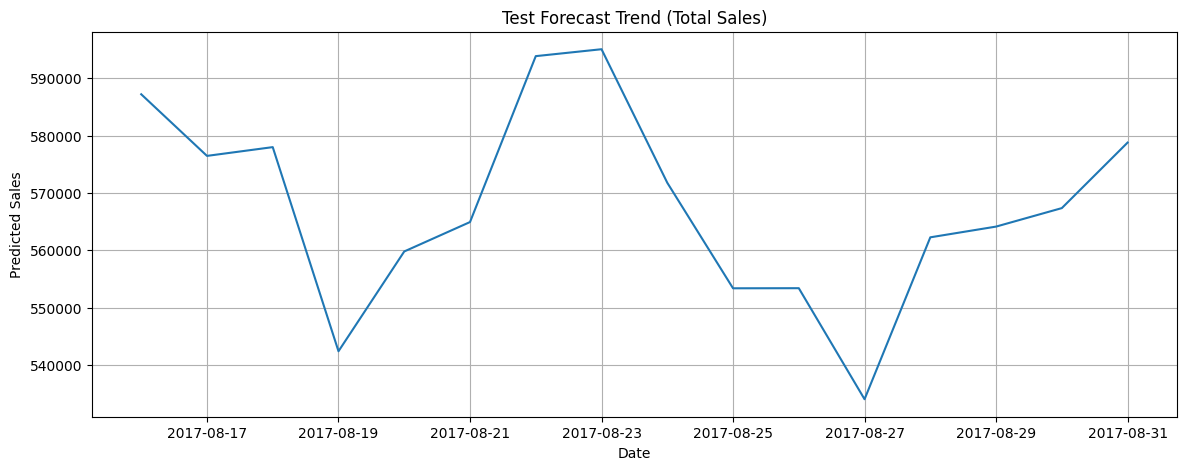

In [68]:
# Plot Test Forecast Trend
daily_forecast = (
    test.groupby("date")["sales_pred"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 5))
plt.plot(daily_forecast["date"], daily_forecast["sales_pred"])
plt.title("Test Forecast Trend (Total Sales)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.show()


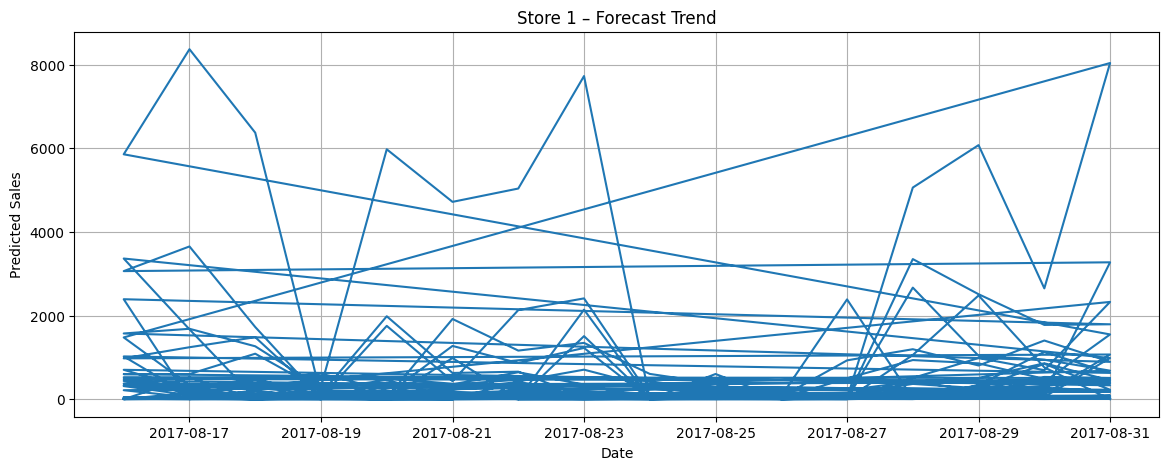

In [69]:
# Store-wise Forecast Plot
sample_store = test["store_nbr"].iloc[0]

store_forecast = test[test["store_nbr"] == sample_store]

plt.figure(figsize=(14, 5))
plt.plot(store_forecast["date"], store_forecast["sales_pred"])
plt.title(f"Store {sample_store} – Forecast Trend")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.show()
